In [1]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm


In [3]:
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor


print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

/Users/aidenchang/miniforge3/envs/ml_final/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 2.1.0; Torch-cuda version: None; Torch Geometric version: 2.4.0.


In [4]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
import pandas as pd
import json

# reviews = pd.read_csv("Gift_Cards.csv")
review_data = []
review_name = 'Gift_Cards_5.json'
with open(review_name, 'r') as file:
    for line in file:
      review_data.append(json.loads(line))
file_metadata = []
metadata_link = "meta_Gift_Cards.json"
with open(metadata_link, 'r') as file:
    for line in file:
      file_metadata.append(json.loads(line))

In [6]:
categories_names = []
for line in file_metadata:
    for cat in line['category']:
        if cat not in categories_names:
            categories_names.append(cat)
        

In [7]:
categories_names

['Gift Cards',
 'Gift Card Accessories',
 '</span></span></span>',
 'No expiration, no fees.',
 'Redeemable toward millions of items storewide on Amazon.com.',
 'Multiple denominations. Choose your amount from $1.00 to $2,000.',
 'Variety of designs for any occasion.',
 'Made with thick, 100% recycled paper stock, sealed with vinyl laminate and hand sewn with clear vinyl pockets',
 "Holds Credit Cards, Business Cards, ID's and or Bus & Train Passes",
 'Great for "going out" or by the pool when just the essentials are needed',
 'Unique, eye-catching designs which rival boring, plain card cases',
 'Handmade with recycled materials in Los Angeles',
 'Starbucks Gift Card 25',
 'Starbucks']

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(categories_names)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

def vec_to_category(vector) -> str:
    return label_encoder.inverse_transform([np.argmax(vector)])[0]

def categories_to_vec(categories):
    categories = list(set(categories))
    integer_encoded = label_encoder.transform(categories)
    integer_encoded = integer_encoded.reshape(-1, 1)
    onehot_encoded = onehot_encoder.transform(integer_encoded)
    # print(onehot_encoded)
    output = onehot_encoded[0]
    for i in range(1, len(onehot_encoded)):
        output += onehot_encoded[i]
    return output

print(categories_to_vec(['Gift Cards', 'Gift Card Accessories']))

[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/Users/aidenchang/miniforge3/envs/ml_final/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
##Defining classes

class Product:
  def __init__(self, title, asin, description, also_bought, categories):
    self.title = title #name, string
    self.asin = asin #string
    self.description = description #string
    # self.features = features # String[]
    self.also_bought = also_bought #asin[]
    if len(categories) == 0:
      self.categories = np.zeros(shape=(len(onehot_encoded)))
    else:
      self.categories = categories_to_vec(categories) #categories[]


  def __str__(self):
    return f"Product {self.title}"

# class Category:
#   def __init__(self, name):
#     self.name = name
#     self.products = []

#   def add_to_category(self, product):
#     self.products.append(product)

#   def __str__(self):
#     return f"Category {self.name} has {len(self.products)} in it."

class User:
  def __init__(self, reviewerID):
    self.reviewerID = reviewerID
    self.products_reviewed = []
    #maybe we can add the categories that they reviewed?

  def add_to_reviewed(self, product):
    self.products_reviewed.append(product)

  def __str__(self):
    return f"User {self.reviewerID} has reviewed {len(self.products_reviewed)} products"

In [27]:
products = {}
all_categories = {}
users = {}

def process_review_data(review):
  try:
    userID = review['reviewerID']
  except:
    print(review)
  if userID not in users:
    new_user = User(userID)
    users[userID] = new_user
  rating = int(review['overall'])
  users[userID].add_to_reviewed((review['asin'], rating))

def process_metadata(metadata):
  asin = metadata['asin']
  # features = metadata['features']
  also_bought = metadata['also_buy']
  title = metadata['title']
  metadata['description'].insert(0, title)
  description = metadata['description']
  categories = metadata['category']
  if asin not in products:
    new_product = Product(title, asin, description, also_bought, categories)
    products[asin] = new_product
  # for category in categories:
  #   if category not in all_categories:
  #     all_categories[category] = Category(category)
  #   all_categories[category].add_to_category(asin)


def load_data():
  for line in review_data:
    process_review_data(line)
  for line in file_metadata:
    process_metadata(line)

load_data()

In [28]:
all_categories

{}

In [29]:
import torch
from torch_geometric.data import Data

# Create instances of your classes
# This is just a placeholder. Replace this with your actual data.
# products = [...]
# categories = [...]
# users = [...]

# Create mappings from unique IDs to consecutive integers
unique_user_id = [user for user in users]
unique_user_id = pd.DataFrame(data={
   'userId': unique_user_id,
   'mappedID': pd.RangeIndex(len(unique_user_id)),
})

unique_product_id = [product for product in products]
unique_product_id = pd.DataFrame(data={
   'productId': unique_product_id,
   'mappedID': pd.RangeIndex(len(unique_product_id)),
})

# unique_category_id = [category for category in all_categories]
# unique_category_id = pd.DataFrame(data={
#    'categoryId': unique_category_id,
#    'mappedID': pd.RangeIndex(len(unique_category_id)),
# })
# print(unique_user_id)
# Construct the edge indices
# User to Product (Review)
user_product_edges = []
user_product_ratings = []
for user_name in users:
   user_object = users[user_name]
   for product_id, rating in users[user_name].products_reviewed:
      product = products[product_id]
      user_product_edges.append([unique_user_id.loc[unique_user_id['userId'] == user_object.reviewerID, 'mappedID'].values[0],
                              unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]])
      user_product_ratings.append(rating)
user_product_edges = torch.t(torch.tensor(user_product_edges, dtype=torch.long))
user_product_ratings = torch.tensor(user_product_ratings, dtype=torch.float) 
# user_product_ratings = torch.reshape(user_product_ratings, (1, len(user_product_ratings)))

print(user_product_edges.shape)

# Product to Product (Also Bought)
product_product_edges = []
for product_id in products:
   product = products[product_id]
   for also_bought_product in products[product_id].also_bought:
      #  print(also_bought_product)
 
       if (unique_product_id['productId'] == also_bought_product).any():  
         product_product_edges.append([unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0],
                                   unique_product_id.loc[unique_product_id['productId'] == also_bought_product, 'mappedID'].values[0]])
# print(len(product_product_edges))
product_product_edges = torch.t(torch.tensor(product_product_edges, dtype=torch.long))


torch.Size([2, 2972])


In [30]:
from sentence_transformers import SentenceTransformer

class TextEncoder:
    """
    A class for encoding text using a SentenceTransformer model.
    """
    def __init__(self, model='all-MiniLM-L6-v2', device=None):
        """
        :param model: Name of the SentenceTransformer model to use.
        :param device: Device to use for model inference. Default is None.
        """
        self.device = device
        self.model = SentenceTransformer(model, device=self.device)

    @torch.no_grad()
    def __call__(self, values: list):
        """
        Encode a list of text values into embeddings.

        :param values: List of text values to encode.
        :return: Encoded embeddings as a PyTorch tensor.
        """
        x = self.model.encode(values,
                              show_progress_bar=True,
                              convert_to_tensor=True,
                              device=self.device)
        return x.cpu()


# Check if CUDA is available, and set the device accordingly
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# Create an instance of the TextEncoder class with the determined device
encoder = TextEncoder(device=device)

In [34]:
print(products['B002VFYGC0'].description)

 Maggiano&#39;s Gift Card Maggiano&#39;s Gift Card Maggiano&#39;s Gift Card Maggiano&#39;s Gift Card


In [32]:
# Create product features

product_features = torch.zeros((len(unique_product_id), 384+onehot_encoded.shape[0]))
for product_id in products:
    product = products[product_id]
    mapped_id = unique_product_id.loc[unique_product_id['productId'] == product.asin, 'mappedID'].values[0]
    one_hot = torch.tensor(product.categories)
    d = ""
    for descrip in product.description:
        d = d + descrip
    product.description = d
    if product.description == "":
        product_features[mapped_id] = torch.cat((encoder("None"), one_hot), -1)
    else:
        product_features[mapped_id] = torch.cat((encoder(product.description), one_hot), -1)
        

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 54.39it/s]


In [36]:
product_features.shape

torch.Size([1547, 398])

In [40]:
from torch_geometric.data import HeteroData
data = HeteroData()

# Add node features to the HeteroData object
data['Product'].x = product_features
# data['User'].x = torch.ones(len(users), 1)
data['User'].x = torch.eye(len(users))

# Add edge indices to the HeteroData object
data['User', 'REVIEWS', 'Product'].edge_index = user_product_edges
data['User', 'REVIEWS', 'Product'].edge_label = user_product_ratings
data['Product', 'ALSO_BOUGHT', 'Product'].edge_index = product_product_edges

import torch_geometric.transforms as T
data = T.ToUndirected()(data)

del data['Product', 'rev_REVIEWS', 'User'].edge_label


In [41]:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('User', 'REVIEWS', 'Product'), ('Product', 'ALSO_BOUGHT', 'Product')],
    rev_edge_types=[('Product', 'rev_REVIEWS', 'User'),('Product', 'rev_ALSO_BOUGHT', 'Product')],
)(data)
train_data, val_data

# train_data, val_data, test_data = T.RandomLinkSplit(
#     num_val=0.1,
#     num_test=0.1,
#     neg_sampling_ratio=0.0,
#     edge_types=[('User', 'REVIEWS', 'Product')],
#     rev_edge_types=[('Product', 'rev_REVIEWS', 'User')],
# )(data)
train_data, val_data

(HeteroData(
   Product={ x=[1547, 398] },
   User={ x=[458, 458] },
   (User, REVIEWS, Product)={
     edge_index=[2, 2378],
     edge_label=[2378],
     edge_label_index=[2, 2378],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8458],
     edge_label=[8458],
     edge_label_index=[2, 8458],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 2378] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ),
 HeteroData(
   Product={ x=[1547, 398] },
   User={ x=[458, 458] },
   (User, REVIEWS, Product)={
     edge_index=[2, 2378],
     edge_label=[297],
     edge_label_index=[2, 297],
   },
   (Product, ALSO_BOUGHT, Product)={
     edge_index=[2, 8458],
     edge_label=[1057],
     edge_label_index=[2, 1057],
   },
   (Product, rev_REVIEWS, User)={ edge_index=[2, 2378] },
   (Product, rev_ALSO_BOUGHT, Product)={}
 ))

In [47]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['User'][row], z_dict['Product'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        edge_index_dict = {k: v.to(torch.long).view(2, -1) for k, v in edge_index_dict.items()}
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model(hidden_channels=32).to(device)

print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
    (conv2): ModuleDict(
      (User__REVIEWS__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__ALSO_BOUGHT__Product): SAGEConv((-1, -1), 32, aggr=mean)
      (Product__rev_REVIEWS__User): SAGEConv((-1, -1), 32, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=64, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [44]:
train_data.edge_index_dict

{('User',
  'REVIEWS',
  'Product'): tensor([[ 242,   81,  446,  ...,  398,  360,  221],
         [ 666,  306, 1005,  ..., 1377,  973, 1231]]),
 ('Product',
  'ALSO_BOUGHT',
  'Product'): tensor([[ 282,  275,  704,  ...,  282,  454,  275],
         [ 463,  662,  709,  ..., 1404,  485, 1410]]),
 ('Product',
  'rev_REVIEWS',
  'User'): tensor([[ 666,  306, 1005,  ..., 1377,  973, 1231],
         [ 242,   81,  446,  ...,  398,  360,  221]])}

In [52]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['User', 'Product'].edge_label_index)
    target = train_data['User', 'Product'].edge_label
    loss = F.mse_loss(pred, target)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    data = data.to(device)
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

epochs = 200
t_loss = []
v_loss = []
for epoch in range(1, epochs):
    train_data = train_data.to(device)
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    t_loss.append(train_rmse)
    v_loss.append(val_rmse)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}')

Epoch: 001, Loss: 0.1055, Train: 0.5528, Val: 0.6037
Epoch: 002, Loss: 0.3056, Train: 0.4336, Val: 0.4785
Epoch: 003, Loss: 4.5048, Train: 0.3209, Val: 0.4200
Epoch: 004, Loss: 0.1192, Train: 1.2253, Val: 1.2374
Epoch: 005, Loss: 1.5013, Train: 1.6398, Val: 1.6444
Epoch: 006, Loss: 2.6889, Train: 1.5387, Val: 1.5449
Epoch: 007, Loss: 2.3675, Train: 1.0697, Val: 1.0870
Epoch: 008, Loss: 1.1442, Train: 0.3910, Val: 0.4699
Epoch: 009, Loss: 0.1530, Train: 0.3820, Val: 0.4436
Epoch: 010, Loss: 0.6428, Train: 0.4094, Val: 0.4590
Epoch: 011, Loss: 1.4801, Train: 0.3923, Val: 0.4489
Epoch: 012, Loss: 0.8473, Train: 0.3308, Val: 0.4173
Epoch: 013, Loss: 0.1467, Train: 0.5306, Val: 0.5811
Epoch: 014, Loss: 0.2816, Train: 0.8474, Val: 0.8719
Epoch: 015, Loss: 0.7182, Train: 0.9187, Val: 0.9391
Epoch: 016, Loss: 0.8440, Train: 0.7644, Val: 0.7916
Epoch: 017, Loss: 0.5843, Train: 0.4731, Val: 0.5278
Epoch: 018, Loss: 0.2239, Train: 0.3260, Val: 0.4117
Epoch: 019, Loss: 0.1192, Train: 0.3593, Val: 

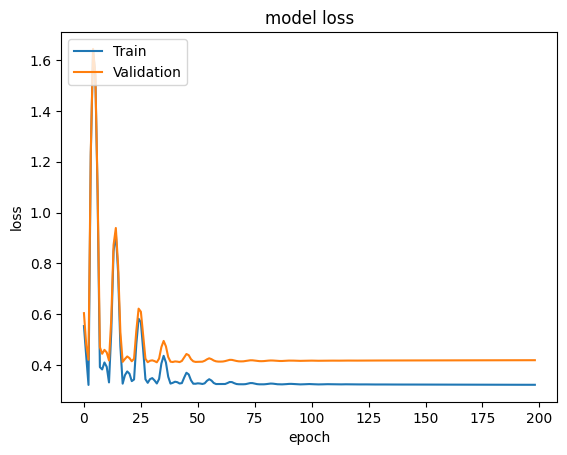

In [53]:
import matplotlib.pyplot as plt
plt.plot(t_loss)
plt.plot(v_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [49]:
with torch.no_grad():
    test_data = test_data.to(device)
    pred = model(test_data.x_dict, test_data.edge_index_dict,
                 test_data['User', 'Product'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = test_data['User', 'Product'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    print(f'Test RMSE: {rmse:.4f}')

userId = test_data['User', 'Product'].edge_label_index[0].cpu().numpy()
prodId = test_data['User', 'Product'].edge_label_index[1].cpu().numpy()
pred = pred.cpu().numpy()
target = target.cpu().numpy()

print(pd.DataFrame({'userId': userId, 'ProdId': prodId, 'rating': pred, 'target': target}))

Test RMSE: 0.2904
     userId  ProdId    rating  target
0       437    1028  5.000000     5.0
1       226     610  5.000000     5.0
2       323     306  5.000000     5.0
3        15    1232  5.000000     5.0
4        54     704  4.955785     5.0
..      ...     ...       ...     ...
292     227    1179  5.000000     5.0
293     246     584  4.969073     5.0
294     177     446  4.862944     4.0
295     116     308  3.726290     3.0
296     331     483  5.000000     5.0

[297 rows x 4 columns]
